#                                     Customer Segmentation

### Module Import :

Let's first go ahead and import the necessary modules required for this project.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.cm as cm

%matplotlib inline

The following command can be used to identify the working directory

In [23]:
%pwd

'C:\\Users\\roopa'

### Data Preprocessing :

Let's now read the data file.

In [24]:
df = pd.read_excel('/Users/roopa/Downloads/Online Retail.xlsx')

To know the dimensions of the dataframe and to viw the first 3 rows, we can use the following statements:

In [25]:
print(df.shape)
df.head(3)

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


To know the dataset information, the following command can be used:

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


We can now find out the percentage of missing values for each column in the dataset:

In [27]:
null_vals = df.isnull().sum()/len(df)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent Missing"]
null_vals

,Feature,Percent Missing
0,InvoiceNo,0.000000
1,StockCode,0.000000
2,Description,0.268311
3,Quantity,0.000000
4,InvoiceDate,0.000000
5,UnitPrice,0.000000
6,CustomerID,24.926694
7,Country,0.000000


Let's now view this percentage graphically:

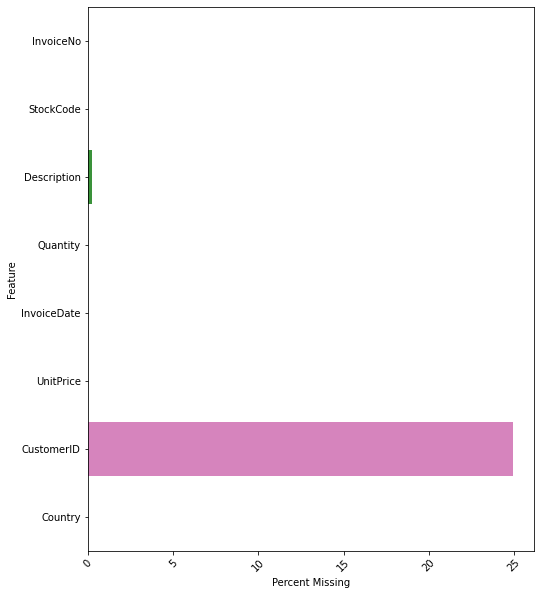

In [28]:
plt.figure(figsize=(8,10))
plt.xticks(rotation = 45)
sns.barplot(x = "Percent Missing", y = "Feature", data = null_vals, orient = 'h')

It can be seen from the plot that CustomerID and Description columns contain null values. We can now delete the missing rows in these two columns.

In [29]:
df1 = df.dropna(subset = ["CustomerID","Description"])
print(df.shape, df1.shape)

(541909, 8) (406829, 8)


There might be still duplicate rows in the datframe. We have only removed the missing values till now. In order to remove the duplicates from the datframe, we can use the following statement:

In [30]:
df2 = df1.drop_duplicates()
print(df2.shape)

(401604, 8)


We can now analyze the columns. There are 8 features in total, out of which StockCode, Description and Country are quite unimportant in the given problem context. Therefore we can go ahead and create another dataframe with only the required features.

In [32]:
df3 = df2[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]
print(df3.shape)
df3.head(2)

(401604, 5)


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55
1,17850.0,2010-12-01 08:26:00,536365,6,3.39


We can see that the total price is not given. We can find out the total price for each product bought by a particular customer by taling the product of quantity and unit price of that particular product.

In [37]:
df3['TotalPrice'] = df3['Quantity'] * df3['UnitPrice']
print(df3.shape)
df3.head(2)

(401604, 7)


C:\Users\roopa\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,Total Price,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,20.34


We can now find out the earliest and latest transactions in the dataset

In [34]:
print('Min:{};Max:{}'.format(df3['InvoiceDate'].min(),df3['InvoiceDate'].max()))

Min:2010-12-01 08:26:00;Max:2011-12-09 12:50:00


Let's go ahead and pick a reference date ( Here, its 1 day after the max invoice date)

In [38]:
current_date = dt.datetime(2011,12,10)
current_date

datetime.datetime(2011, 12, 10, 0, 0)

Next, we can calculate the aggregates : Recency, Frequency and Monetary
Recency : last transcation for each customer
Frequency : how frequently each customer shops
Monetary : Total amount spent by each customer

In [76]:
df4 = df3.groupby(['CustomerID']).agg({'InvoiceDate': lambda x:(current_date-x.max()).days,
                                       'InvoiceNo':'count',
                                       'TotalPrice':'sum'})
df4 = df4.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalPrice':'Monetary'})
print(df4.shape)
df4.head(3)

(4372, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24


Here, for the first customer we can see that the monetary value is 0. This can be because of various reasons. One of the reasons might be because the customer might have bought something and then returned it, so that the transaction entry is updated as 0. We have to remove rows with zero values as this doesnt come under our analysis.

In [77]:
df5 = df4[(df4>0).all(1)]
print(df5.shape)
df5.head(3)

(4284, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55


K-Means algorithm has a few key assumptions:
1. The clusters are spherical in shape
2. Features have the same mean
3. Features have the same variance

Let's go ahead and check these assumptions:

In [78]:
df5.describe()

,Recency,Frequency,Monetary
count,4284.000000,4284.000000,4.284000e+03
mean,90.676471,90.185341,1.802891e+03
std,99.211872,217.749743,7.226246e+03
min,1.000000,1.000000,1.243450e-14
25%,17.000000,18.000000,2.988725e+02
50%,50.000000,42.000000,6.467200e+02
75%,140.000000,99.000000,1.596963e+03
max,373.000000,7812.000000,2.794890e+05


Except for InvoiceDate and InvoiceNo having almost similar mean, none of the other features have same mean nor variance. So we need to transform the data i.e scale/standardize the data

Also, let's check whether the distribution is skewed or not.

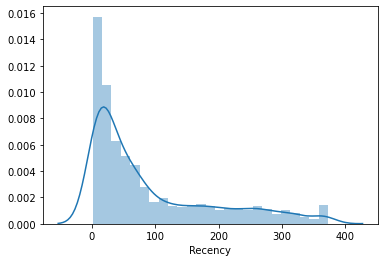

In [79]:
sns.distplot(df5['Recency'])

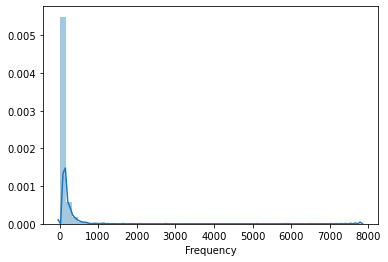

In [80]:
sns.distplot(df5['Frequency'])

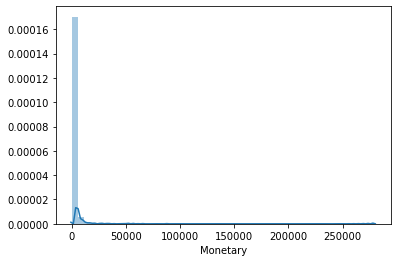

In [82]:
sns.distplot(df5['Monetary'])

It looks like the data is skewed. We can try transforming the data by taking the log of the features. An extra 1 is added to offset any negative values.

In [83]:
df6 = (np.log(df5+1))
print(df6.shape)
df6

(4284, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12347.0,1.098612,5.209486,8.368925
12348.0,4.330733,3.465736,7.494564
12349.0,2.944439,4.304065,7.472245
12350.0,5.739793,2.890372,5.815324
12352.0,3.610918,4.564348,7.343691
...,...,...,...
18280.0,5.627621,2.397895,5.201806
18281.0,5.198497,2.079442,4.404522
18282.0,2.079442,2.639057,5.179534


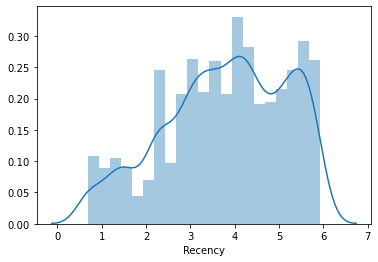

In [84]:
sns.distplot(df6['Recency'])

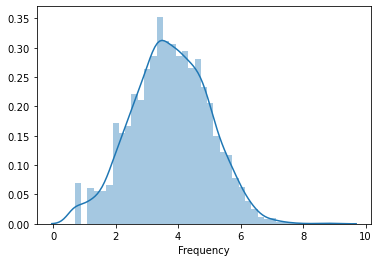

In [86]:
sns.distplot(df6['Frequency'])

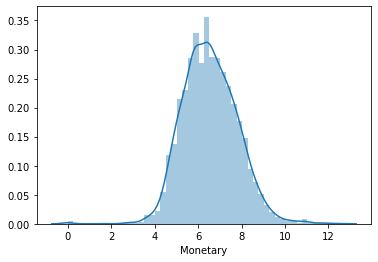

In [87]:
sns.distplot(df6['Monetary'])

Let's now perform data scaling to make the mean and variance of all columns equal

In [89]:
scalar = StandardScaler()
scalar.fit(df6)
df7 = pd.DataFrame(scalar.transform(df6))
df7.columns = df6.columns
df7.describe()

,Recency,Frequency,Monetary
count,4.284000e+03,4.284000e+03,4.284000e+03
mean,-7.420114e-17,-2.576267e-16,-9.003069e-17
std,1.000117e+00,1.000117e+00,1.000117e+00
min,-2.257036e+00,-2.483041e+00,-5.244693e+00
25%,-6.530502e-01,-6.528544e-01,-6.740816e-01
50%,1.072168e-01,1.113110e-02,-5.693016e-02
75%,8.495844e-01,6.972361e-01,6.667453e-01
max,1.561702e+00,4.240374e+00,4.805312e+00


Now, all the features have almost the same mean and variance! Let's now proceed with the K-Means clustering.

### K-Means Algorithm

In [90]:
k_means = KMeans(n_clusters = 2, random_state = 1)

In [95]:
'''Let's see how this works. Apply kmeans on the preprocessed data and get cluster labels for ech row'''
k_means.fit(df7)
clus_labels = k_means.labels_
clus_labels

array([1, 0, 1, ..., 0, 1, 1])

In [97]:
'''We are interested in the non -log tranformed features'''
df5_clus2 = df5.assign(Cluster = clus_labels)
print(df5_clus2.shape)
df5_clus2.head(3)

(4284, 4)


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12347.0,2,182,4310.00,1
12348.0,75,31,1797.24,0
12349.0,18,73,1757.55,1


In [98]:
df5_clus2.groupby(['Cluster']).agg({'Recency':'mean','Frequency':'mean','Monetary':['mean','count']}).round(0)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         139.0      25.0    427.0  2376
1          30.0     171.0   3517.0  1908